### Code reviewer

As an assignment task we need to create code reviewer agent who can able write code based on description, and send the code to reviewer and finally add the doc_string if not exist

In [12]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    description: str
    code: str
    review_done: str
    review_score: str
    doc_string_available: str
    final_code: str




In [13]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="qwen-2.5-32b")
res = llm.invoke("Hello how are you")
res

AIMessage(content="Hello! As an AI, I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 33, 'total_tokens': 63, 'completion_time': 0.15, 'prompt_time': 0.003909236, 'queue_time': 0.46568252800000004, 'total_time': 0.153909236}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-9c3da41d-ed49-4ee9-9960-f7e4c58eb3c0-0', usage_metadata={'input_tokens': 33, 'output_tokens': 30, 'total_tokens': 63})

In [14]:
res = llm.invoke("generate code for prime number in python ")
res.content

'Sure, I can help you write a Python function to check if a number is prime and also to generate a list of prime numbers up to a certain limit. Here are two different functions for these purposes:\n\n1. A function to check if a single number is prime:\n```python\ndef is_prime(n):\n    """Check if a number is a prime number."""\n    if n <= 1:\n        return False\n    if n <= 3:\n        return True\n    if n % 2 == 0 or n % 3 == 0:\n        return False\n    i = 5\n    while i * i <= n:\n        if n % i == 0 or n % (i + 2) == 0:\n            return False\n        i += 6\n    return True\n```\n\n2. A function to generate all prime numbers up to a given limit `n`:\n```python\ndef generate_primes(n):\n    """Generate a list of prime numbers up to a given limit."""\n    primes = []\n    for number in range(2, n + 1):\n        if all(number % i != 0 for i in range(2, int(number**0.5) + 1)):\n            primes.append(number)\n    return primes\n```\n\nYou can use the first function `is_p

In [15]:
r1 = llm.invoke(f"based on provided {res.content} analyze the code and provide the review feedback.\
                provide the score out of 1-10 exampl like Score: 5 at the end ")
r1.content

'The provided functions for checking if a number is prime and generating a list of prime numbers up to a certain limit are both generally well-structured and functional. However, there are some areas where the code could be improved for efficiency and readability.\n\n### Review of `is_prime` Function\n\n- **Efficiency**: The function `is_prime` is quite efficient. It reduces the number of divisions needed by checking divisibility by 2 and 3, and then only considering factors of the form 6k ± 1. This is a common and effective optimization for prime checking.\n- **Readability**: The function is clear and straightforward. The logic is well-commented in the form of the function docstring.\n- **Edge Cases**: The function correctly handles edge cases such as `n <= 1` and `n <= 3` by returning `False` or `True` directly.\n\n### Review of `generate_primes` Function\n\n- **Efficiency**: While the function `generate_primes` is correct, it can be optimized. Checking up to the square root of `numb

In [16]:
r2 = llm.invoke(f"based on provided {r1.content} captuer score and return its type  ")
r2.content

"The score provided is a numerical value, specifically an integer. Thus, the type of the score is `int`.\n\nTo capture and return the type of the score in Python, you can use the built-in `type()` function as shown below:\n\n```python\nscore = 8\nscore_type = type(score)\nprint(score_type)  # <class 'int'>\n```\n\nThis code snippet will output `<class 'int'>`, indicating that the type of the score is an integer."

In [17]:
r4 = llm.invoke(f"based on provided {r2.content} if score is > 5 send classify as 'PASS' else 'FAIL' give only end result")
r4.content

'PASS'

In [18]:
r3 = llm.invoke(f"based on provide {res.content} analyze the code and check if docstring available if not add the docstring. Strictly present only the program")
r3.content

'```python\ndef is_prime(n):\n    """\n    Check if a number is a prime number.\n    \n    :param n: Integer to check for primality.\n    :return: True if n is a prime number, False otherwise.\n    """\n    if n <= 1:\n        return False\n    if n <= 3:\n        return True\n    if n % 2 == 0 or n % 3 == 0:\n        return False\n    i = 5\n    while i * i <= n:\n        if n % i == 0 or n % (i + 2) == 0:\n            return False\n        i += 6\n    return True\n\ndef generate_primes(n):\n    """\n    Generate a list of prime numbers up to a given limit.\n    \n    :param n: Upper limit (inclusive) to generate prime numbers.\n    :return: List of prime numbers up to n.\n    """\n    primes = []\n    for number in range(2, n + 1):\n        if all(number % i != 0 for i in range(2, int(number**0.5) + 1)):\n            primes.append(number)\n    return primes\n```'

In [19]:
#Nodes
def developer(state: State):
    "Based on the description added it will generate code."
    print(state['description'])
    res = llm.invoke(f"Generate the python code based on the provided desctipion: {state['description']}")
    print(res.content)
    return {'code':res.content}

def reviewer(state:State):
    "Based on the review of code copy the review and score to review socre."
    r1 = llm.invoke(f"based on provided {state['code']} analyze the code and provide the review feedback.\
                provide the score out of 1-10 exampl like Score: 5 at the end ")
    print(r1.content)
    r2 = llm.invoke(f"based on provided {r1.content} captuer score and return its type  ")
    print(r2.content)
    return {"review_done":r1.content, "review_score":r2.content}

def check_review(state:State):
    "Baseed on reveiw score we should send to developer"
    c1 = llm.invoke(f"based on provided {state['review_score']} if score is > 5 send classify as 'PASS' else 'FAIL' give only end result")
    print(c1)
    if c1 == "PASS":
        return "PASS"
    return 'FAIL'

def manager(state:State):
    "Based on review it should go to mergeing after final docstring addition"
    m1 = llm.invoke(f"based on provide {state['code']} and {state['review_score']} analyze the code make modifications and check if docstring available if not add the docstring.\
                    Strictly present only the program")
    print(m1.content)
    return {'final_code':m1.content}
    



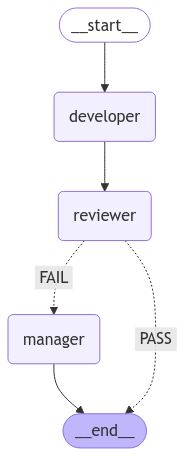

In [20]:
from IPython.display import Image,display
manager_workflow = StateGraph(State)

#Add the nodes
manager_workflow.add_node("developer",developer)
manager_workflow.add_node("reviewer", reviewer)
manager_workflow.add_node("manager",manager)

#add edges
manager_workflow.add_edge(START,"developer")
manager_workflow.add_edge("developer","reviewer")
manager_workflow.add_conditional_edges(
    "reviewer",check_review,{"PASS":END,"FAIL":"manager"}
)
manager_workflow.add_edge("manager",END)

graph = manager_workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
res = graph.invoke({"description":"generate inefficient code for prime number"})
res

generate inefficient code for prime number
Certainly! Below is an example of inefficient Python code to generate a list of prime numbers up to a given number `n`. This code is intentionally inefficient to meet your request.

```python
def is_prime(num):
    if num <= 1:
        return False
    for i in range(2, num):  # Inefficient: it checks all numbers from 2 to num-1
        if num % i == 0:
            return False
    return True

def generate_primes(n):
    primes = []
    for num in range(2, n + 1):
        if is_prime(num):  # Calls the inefficient is_prime function
            primes.append(num)
    return primes

# Example usage
n = 50
print("Prime numbers up to", n, "are:", generate_primes(n))
```

### Explanation of Inefficiencies:
1. **Redundant checks in `is_prime` function**: The function checks divisibility for all numbers from 2 to `num - 1`, even though a number is only divisible by factors up to its square root.
2. **Repeated function calls**: For each number, the `

{'description': 'generate inefficient code for prime number',
 'code': 'Certainly! Below is an example of inefficient Python code to generate a list of prime numbers up to a given number `n`. This code is intentionally inefficient to meet your request.\n\n```python\ndef is_prime(num):\n    if num <= 1:\n        return False\n    for i in range(2, num):  # Inefficient: it checks all numbers from 2 to num-1\n        if num % i == 0:\n            return False\n    return True\n\ndef generate_primes(n):\n    primes = []\n    for num in range(2, n + 1):\n        if is_prime(num):  # Calls the inefficient is_prime function\n            primes.append(num)\n    return primes\n\n# Example usage\nn = 50\nprint("Prime numbers up to", n, "are:", generate_primes(n))\n```\n\n### Explanation of Inefficiencies:\n1. **Redundant checks in `is_prime` function**: The function checks divisibility for all numbers from 2 to `num - 1`, even though a number is only divisible by factors up to its square root.\n